## Neural Network Approach For Functions Of Matrices

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.linalg import expm
import math

import matplotlib.pyplot as plt

import csv
import os

import datetime

In [2]:
ID = datetime.datetime.strftime(datetime.datetime.now(),'%Y%M%d%s')

In [3]:
# Create a directory for saving results
save_dir = os.path.join(os.getcwd(), 'matrix_exp_results', ID)
os.makedirs(save_dir, exist_ok=True)

In [4]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Define the neural network
class MatrixExponentialNet(nn.Module):
    def __init__(self, input_size):
        super(MatrixExponentialNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, input_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [7]:
# Define input size (5x5 matrix flattened)
input_size = 5 * 5

In [8]:
# params
distribution = "gaussian" # or uniform
coeff_lower = 0 
coeff_upper = 10

lr = 1e-5 # learning rate

In [9]:
# Create the model and move it to GPU
model = MatrixExponentialNet(input_size).to(device)

In [10]:
class MatrixLoss(nn.Module):
    def __init__(self, dim=5):
        super(MatrixLoss, self).__init__()
        self.dim = dim

    def forward(self, pred, target):
        e = pred - target
        e_reshaped = e.view(-1, self.dim, self.dim)
        
        max_abs = torch.max(torch.abs(e_reshaped).view(e_reshaped.size(0), -1), dim=1)[0]
        sum_abs = torch.sum(torch.abs(e_reshaped), dim=(1,2)) / self.dim
        trace = torch.sum(e_reshaped ** 2, dim=(1,2)) / self.dim
        
        loss = max_abs + sum_abs + trace
        return loss.mean()

In [11]:
# Define loss function and optimizer
# criterion = nn.MSELoss()
criterion = MatrixLoss(dim=5)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
# Function to compute matrix exponential
def matrix_exponential(batch_matrices):
    return np.array([expm(A) for A in batch_matrices])

In [13]:
# Training loop
num_epochs = 100000
batch_size = 64

In [14]:
# Lists to store loss values for plotting
train_losses = []
val_losses = []

In [15]:
### Custom Loss function

In [16]:
for epoch in range(num_epochs):
    model.train()
    # Generate random 5x5 matrices
    if distribution == "gaussian":
        A = np.random.randn(batch_size, 5, 5)
        A = np.array(coeff_upper / math.sqrt(3.0) * A)
    elif distribution == "uniform":
        A = np.random.rand(batch_size, 5, 5)
        A = np.array(max_coeff * (2 * A - 1))
    else:
        raise TypeError("Unsupported distribution")

    
    # Calculate exp(A)
    A_exp = matrix_exponential(A)
    
    # Convert to PyTorch tensors and move to GPU
    A_tensor = torch.FloatTensor(A).view(batch_size, -1).to(device)
    A_exp_tensor = torch.FloatTensor(A_exp).view(batch_size, -1).to(device)
    
    # Forward pass
    output = model(A_tensor)
    
    # Compute loss
    loss = criterion(output, A_exp_tensor)
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Validation step
    if (epoch + 1) % 1000 == 0:
        model.eval()
        with torch.no_grad():
            if distribution == "gaussian":
                A_val = np.random.randn(batch_size, 5, 5)
                A_val = np.array(coeff_upper / math.sqrt(3.0) * A_val)
            elif distribution == "uniform":
                A_val = np.random.rand(batch_size, 5, 5)
                A_val = np.array(max_coeff * (2 * A_val - 1))
            else:
                raise TypeError("Unsupported distribution")
            # A_val = np.random.randn(batch_size, 5, 5)
            A_exp_val = matrix_exponential(A_val)
            A_val_tensor = torch.FloatTensor(A_val).view(batch_size, -1).to(device)
            A_exp_val_tensor = torch.FloatTensor(A_exp_val).view(batch_size, -1).to(device)
            val_output = model(A_val_tensor)
            val_loss = criterion(val_output, A_exp_val_tensor)
            val_losses.append(val_loss.item())
        
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():,.0f}, Val Loss: {val_loss.item():,.0f}')

Epoch [1000/100000], Train Loss: 180,620,623,385,460,736, Val Loss: 2,265,617,797,218,304
Epoch [2000/100000], Train Loss: 1,010,911,552,733,184, Val Loss: 17,426,043,240,389,279,744
Epoch [3000/100000], Train Loss: 10,054,729,271,290,626,048, Val Loss: 10,001,240,444,370,944
Epoch [4000/100000], Train Loss: 191,239,156,662,272, Val Loss: 231,681,909,019,639,808
Epoch [5000/100000], Train Loss: 121,470,763,281,678,336, Val Loss: 19,240,031,851,905,024
Epoch [6000/100000], Train Loss: 11,191,860,139,655,168, Val Loss: 479,284,426,702,848
Epoch [7000/100000], Train Loss: 718,450,170,986,416,308,224, Val Loss: 4,728,012,205,457,408
Epoch [8000/100000], Train Loss: 2,673,130,199,842,816, Val Loss: 221,877,473,640,448
Epoch [9000/100000], Train Loss: 862,175,033,533,923,328, Val Loss: 52,518,495,023,267,840
Epoch [10000/100000], Train Loss: 615,916,246,029,828,096, Val Loss: 603,302,580,453,376
Epoch [11000/100000], Train Loss: 443,578,346,815,619,072, Val Loss: 4,392,168,796,819,816,448
Ep

In [18]:
# Save the model
torch.save(model.state_dict(), os.path.join(save_dir, 'matrix_exp_model.pth'))

# Save loss lists
with open(os.path.join(save_dir, 'losses.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])
    for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
        writer.writerow([i*100, train_loss, val_loss])

In [32]:
# Evaluation
model.eval()
with torch.no_grad():
    # Generate test matrices
    num_test = 1000

    if distribution == "gaussian":
        A_test = np.random.randn(num_test, 5, 5)
        A_test = np.array(coeff_upper / math.sqrt(3.0) * A_test)
    elif distribution == "uniform":
        A_test = np.random.rand(num_test, 5, 5)
        A_test = np.array(max_coeff * (2 * A_test - 1))
    else:
        raise TypeError("Unsupported distributon.")
    
    A_exp_test = matrix_exponential(A_test)
    
    # Convert to PyTorch tensors and move to GPU
    A_test_tensor = torch.FloatTensor(A_test).view(num_test, -1).to(device)
    A_exp_test_tensor = torch.FloatTensor(A_exp_test).view(num_test, -1).to(device)
    
    # Get model predictions
    predictions = model(A_test_tensor)
    
    # Compute test loss
    test_loss = criterion(predictions, A_exp_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Compare a few results
    for i in range(3):
        print(f"\nExample {i+1}:")
        print("Input matrix A:")
        print(A_test[i])
        print("Actual exp(A):")
        print(A_exp_test[i])
        print("Predicted exp(A):")
        print(predictions[i].view(5, 5).cpu().numpy())

Test Loss: 288444631385546686464.0000

Example 1:
Input matrix A:
[[-7.23298373  4.11937364  0.62292664 10.87093629  2.23151741]
 [-9.34260493  2.45402435 -8.81392734 11.6679538   0.55533743]
 [ 1.56310919  3.59035193  0.21397936 -0.89488649  7.31673767]
 [-1.98572003 -2.0223425   2.89372622 -1.26827436  2.78360117]
 [-4.56090561 -1.6887625  -6.67626007 -8.77067973 11.271082  ]]
Actual exp(A):
[[ -27.60059757   -3.45730879  -15.03111203  -28.43807304   84.83178887]
 [  52.86914709  -19.34610802  -31.17581161  -40.07877875 -129.02466706]
 [ -59.57515951  -44.54067321 -119.18571563 -198.83272412  232.43273761]
 [ -41.2853674     2.74294756   -4.092044    -13.7943263   116.83385837]
 [ -23.97514238  -93.78521651 -224.13214111 -359.25119788  194.35281548]]
Predicted exp(A):
[[153.07974      5.3753395    4.208857    10.757149    -3.3333933 ]
 [ -3.9509356  128.31146    -18.850147   -25.016426     4.0324264 ]
 [ 12.163473     2.704027   150.36699     -0.15654051  -9.265894  ]
 [ 29.056732   

In [33]:
# Save test data and evaluations
with open(os.path.join(save_dir, 'test_data_and_evaluations.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Test Matrix', 'Actual exp(A)', 'Predicted exp(A)', 'Error'])
    for i in range(num_test):
        pred = predictions[i].cpu().numpy().flatten()
        actual = A_exp_test[i].flatten()
        writer.writerow([
            A_test[i].flatten().tolist(),
            actual.tolist(),
            pred.tolist(),
            (pred - actual).tolist()
        ])

In [34]:
print(f"{len(train_losses)=}\n{len(val_losses)=}")

len(train_losses)=100000
len(val_losses)=100


In [35]:
# Visualizations

# 1. Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(range(99, len(train_losses), 1000), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_plot.png'))
plt.close()

In [36]:
# 2. Histogram of Errors
errors = (predictions - A_exp_test_tensor).cpu().numpy().flatten()
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.savefig(os.path.join(save_dir, 'error_histogram.png'))
plt.close()


In [37]:
# 3. Predicted vs Actual Values
plt.figure(figsize=(10, 10))
plt.scatter(A_exp_test_tensor.cpu().numpy().flatten(), predictions.cpu().numpy().flatten(), alpha=0.5)
plt.plot([A_exp_test_tensor.cpu().numpy().min(), A_exp_test_tensor.cpu().numpy().max()], 
         [A_exp_test_tensor.cpu().numpy().min(), A_exp_test_tensor.cpu().numpy().max()], 
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.savefig(os.path.join(save_dir, 'predicted_vs_actual.png'))
plt.close()

In [38]:
# 4. Example Comparison
example_idx = 0
actual = A_exp_test[example_idx]
predicted = predictions[example_idx].view(5, 5).cpu().numpy()

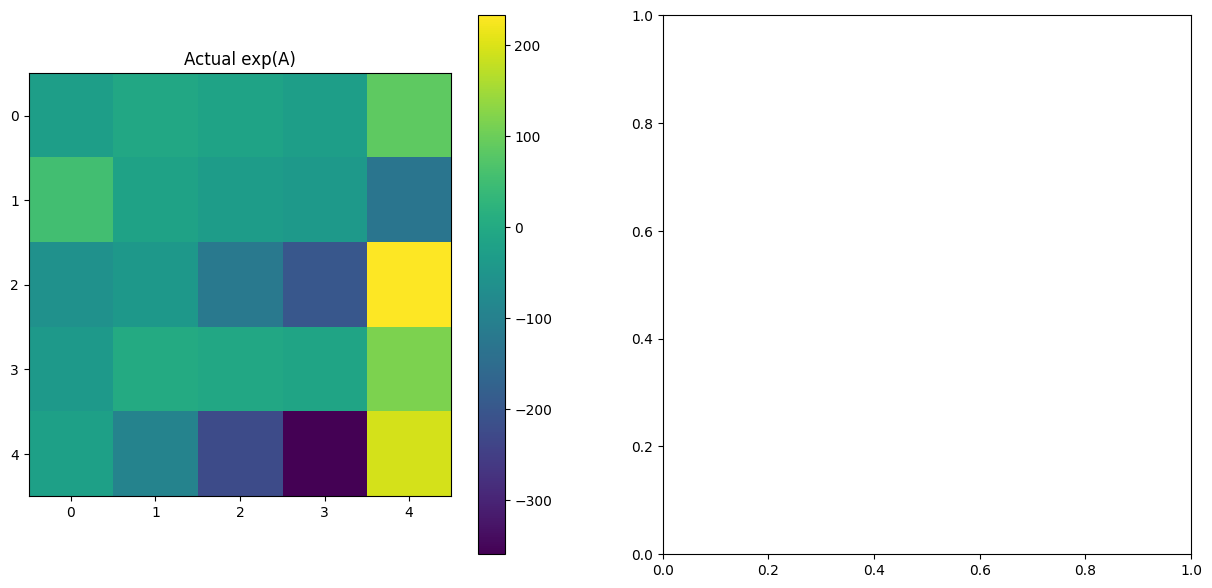

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
im1 = ax1.imshow(actual, cmap='viridis')
ax1.set_title('Actual exp(A)')
plt.colorbar(im1, ax=ax1)

In [40]:
im2 = ax2.imshow(predicted, cmap='viridis')
ax2.set_title('Predicted exp(A)')
plt.colorbar(im2, ax=ax2)

<Figure size 640x480 with 0 Axes>

In [41]:
plt.savefig(os.path.join(save_dir, 'example_comparison.png'))
plt.close()

print("Visualizations have been saved as PNG files.")

Visualizations have been saved as PNG files.


In [42]:
save_dir

'/home/rahulpadmanabhan/Development/ws1/masters_thesis_2/LAWT/notebooks/matrix_exp_results/202405161723781116'